In [78]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np

In [79]:
START_DATE = datetime.date(2020,2,24)

In [80]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str = day.strftime("%Y%m%d")
        filename = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df = pd.read_csv(filename)
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day = day + datetime.timedelta(days = 1)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
#     plt.yscale("log")
    plt.show()
    return

In [81]:
def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str = day.strftime("%Y%m%d")
        filename = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df = pd.read_csv(filename)
        cases[day_str] = int(df[df["denominazione_regione"]==region]["totale_casi"].sum())
        day = day + datetime.timedelta(days = 1)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

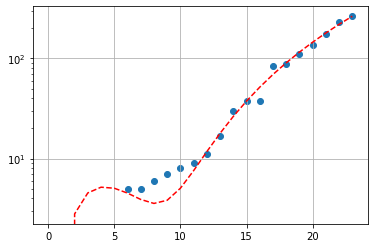

In [82]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

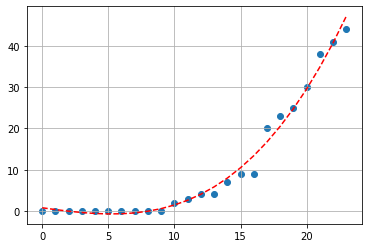

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

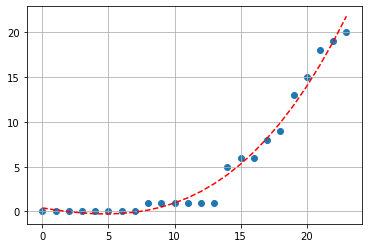

In [84]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

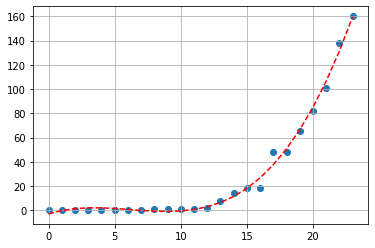

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

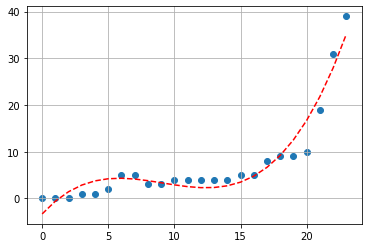

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

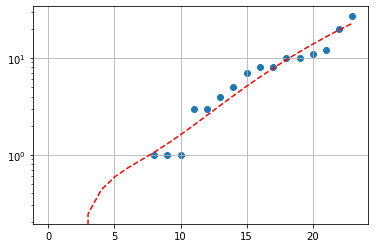

In [87]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

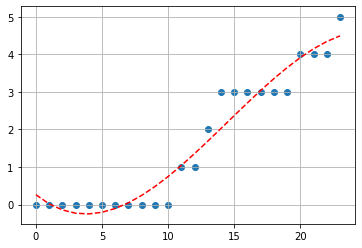

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

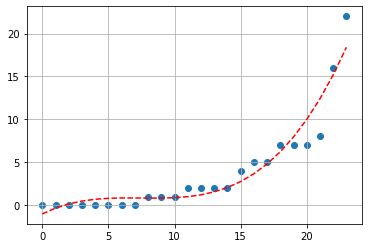

In [89]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

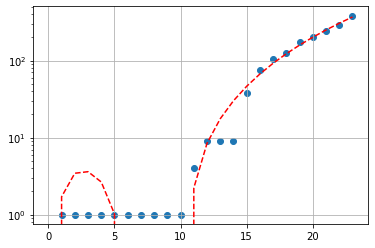

In [90]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

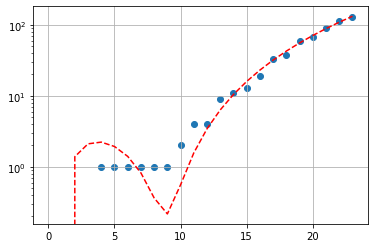

In [91]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

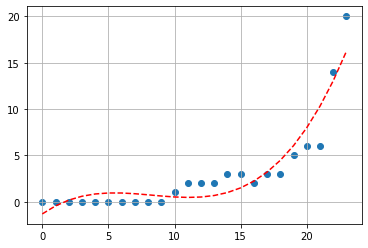

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

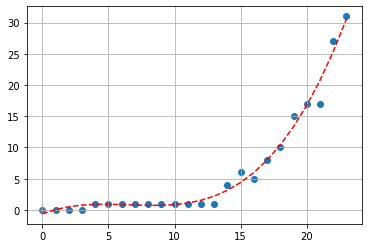

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

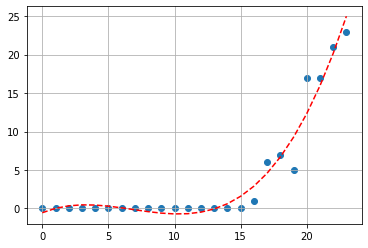

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

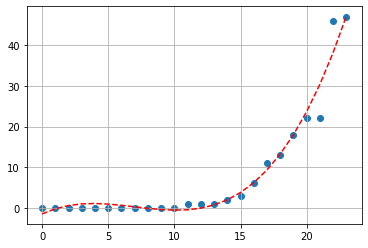

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

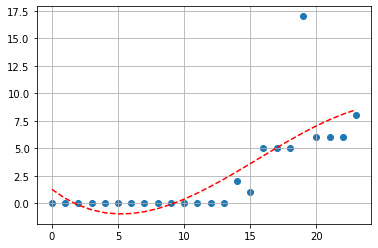

In [96]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

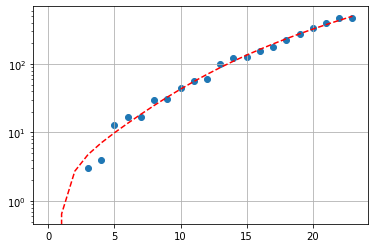

In [97]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

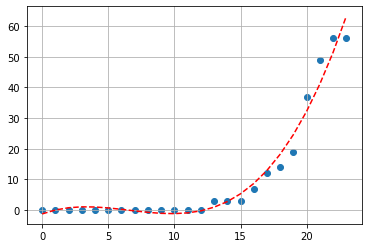

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

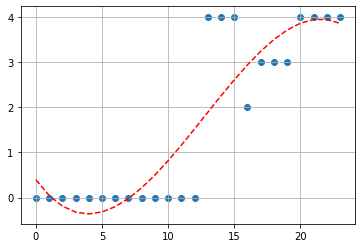

In [99]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

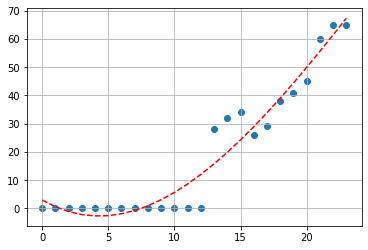

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

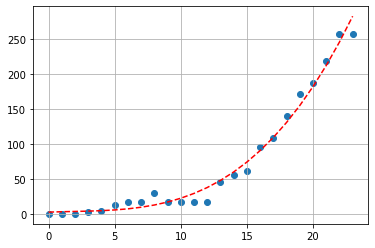

In [101]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

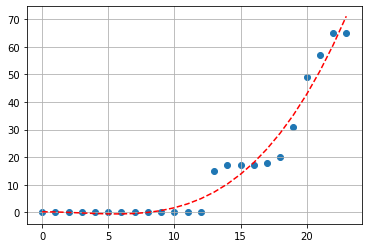

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

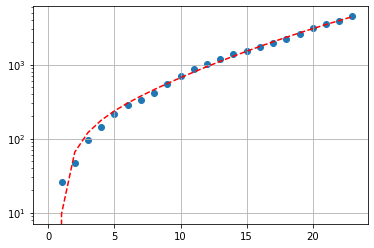

In [103]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

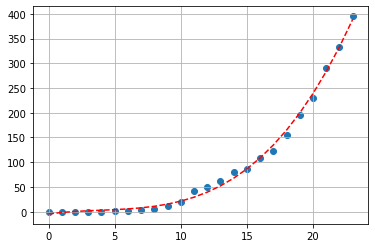

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

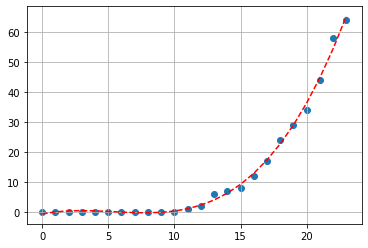

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Forlì-Cesena

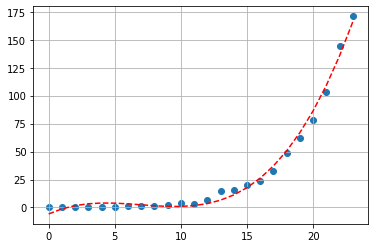

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Forlì-Cesena')

## Modena

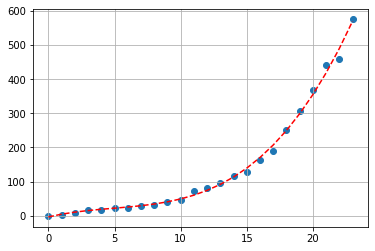

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

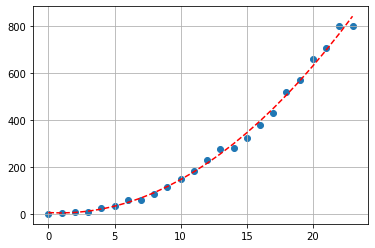

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

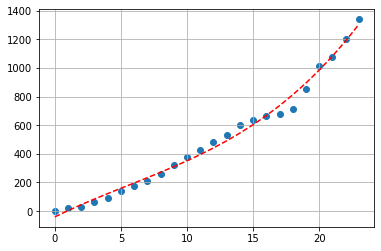

In [109]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

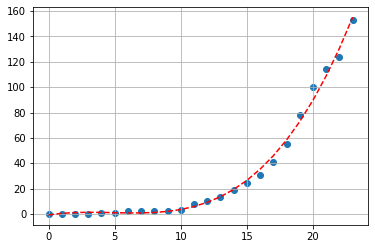

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

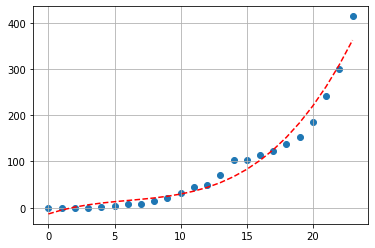

In [111]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

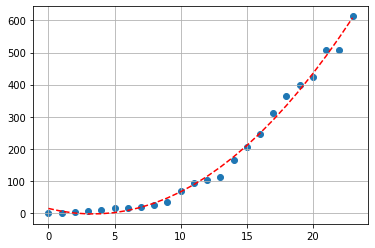

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

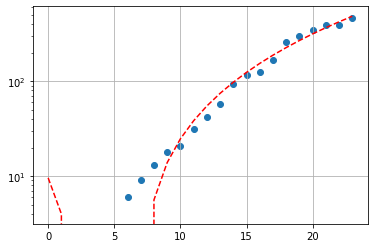

In [113]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

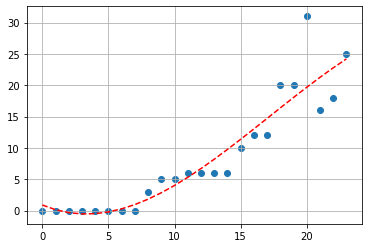

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

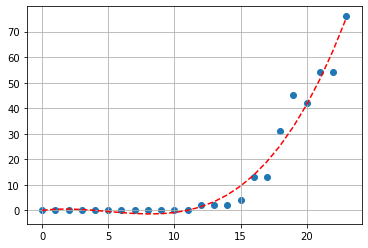

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

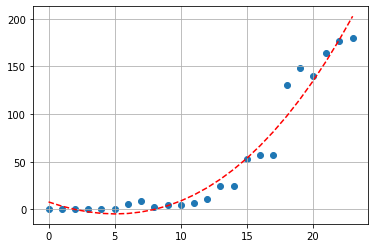

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

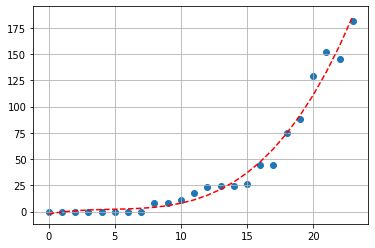

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

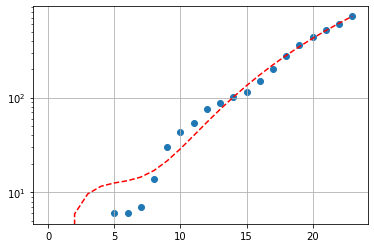

In [118]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

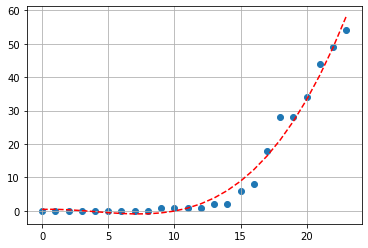

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

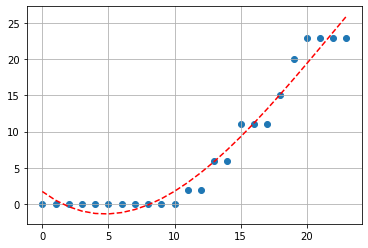

In [120]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

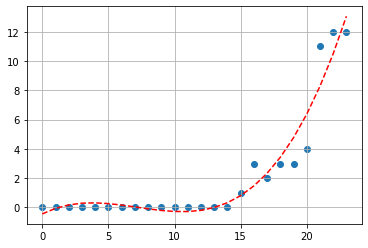

In [121]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

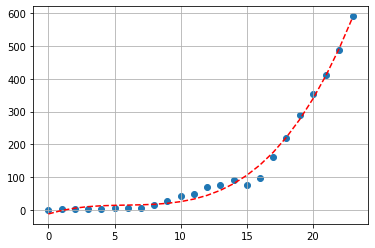

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

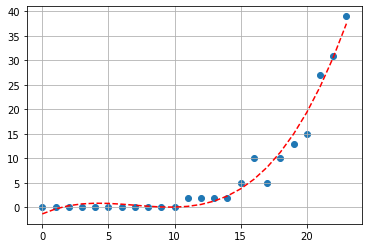

In [123]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

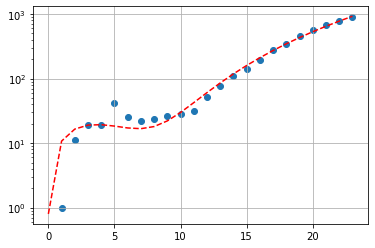

In [124]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

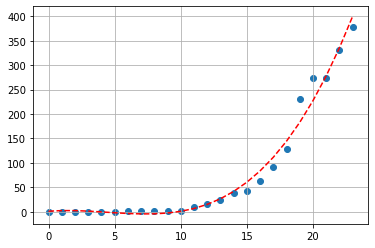

In [125]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

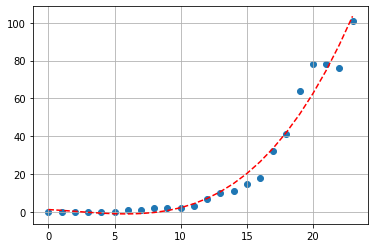

In [126]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

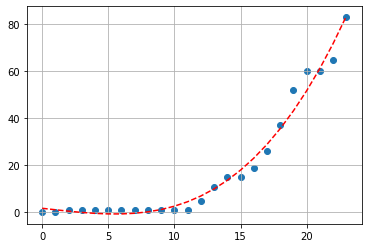

In [127]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

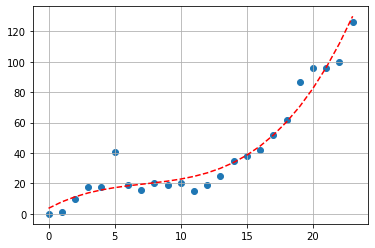

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

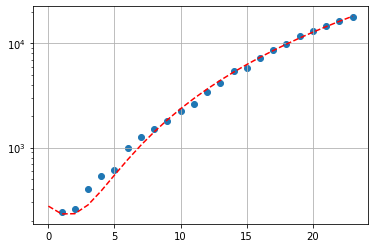

In [129]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

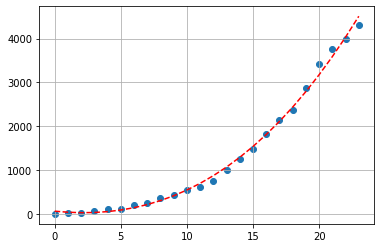

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

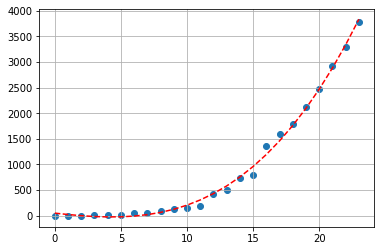

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

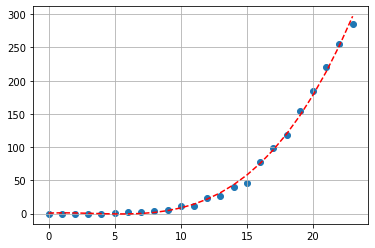

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

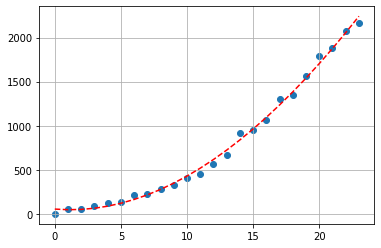

In [133]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

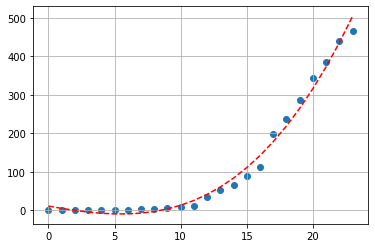

In [134]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

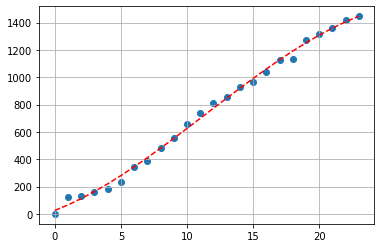

In [135]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

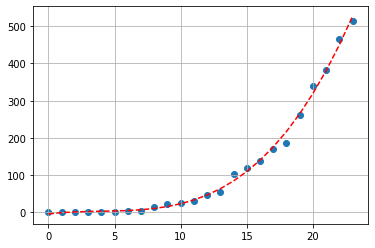

In [136]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

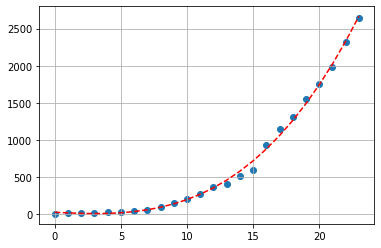

In [137]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

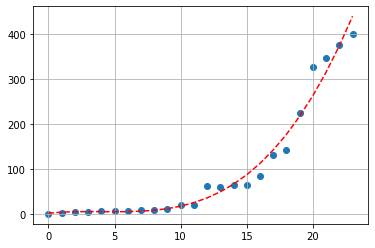

In [138]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

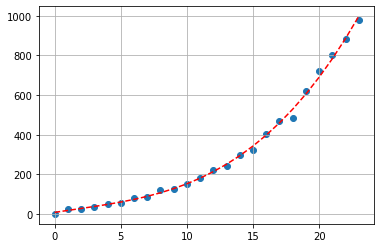

In [139]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

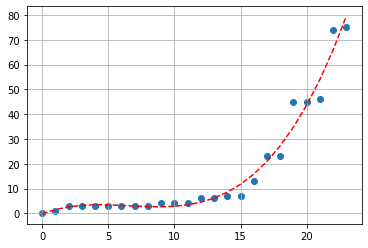

In [140]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

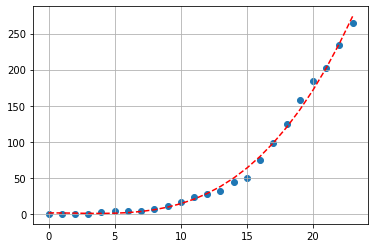

In [141]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

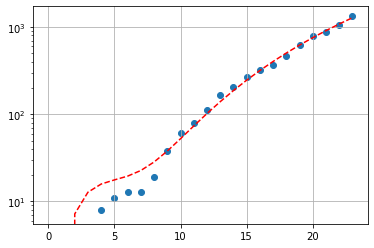

In [142]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

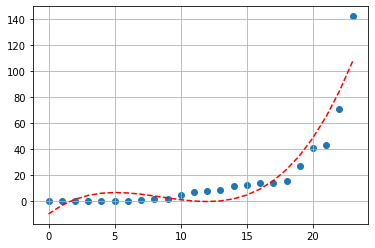

In [143]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

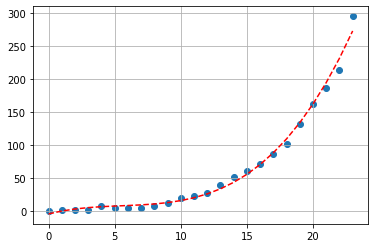

In [144]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

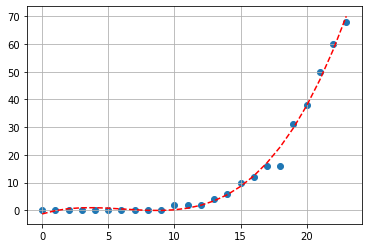

In [145]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

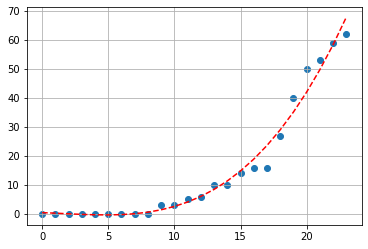

In [146]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

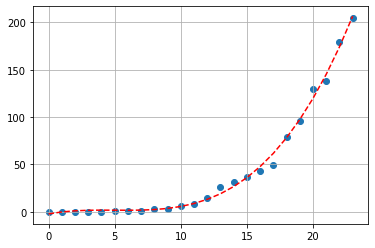

In [147]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

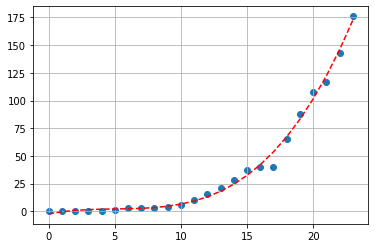

In [148]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

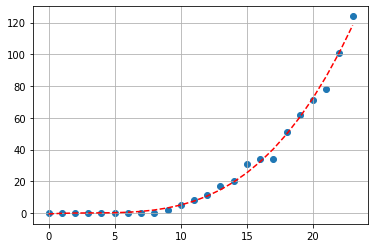

In [149]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

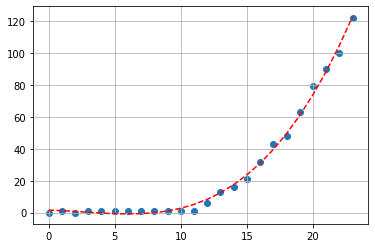

In [150]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

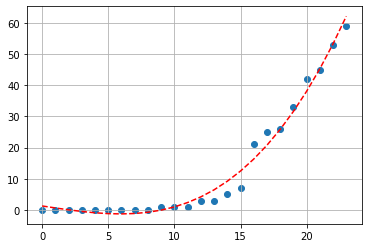

In [151]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

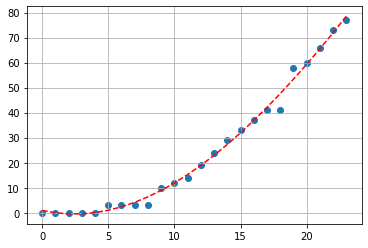

In [152]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi in Veneto

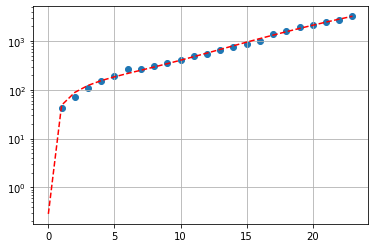

In [153]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Padova

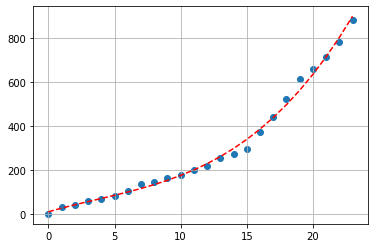

In [154]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')